# Training a Jet Regression with **DNN** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN), also called multi-layer perceptron (MLP). The problem consists is 
regression of $tau_{32}$, given $tau_3$ and $tau_2$.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [ ]:
# ! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
# ! tar -xvzf Data-MLtutorial.tar.gz 
# ! ls Data-MLtutorial/JetDataset/
# ! rm Data-MLtutorial.tar.gz 

In [3]:
target = np.array([])
features = np.array([])
ptype = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(f'../{fileIN}')
    myFeatures = np.array(f.get("jets")[:,[5,6]])
    myptype = np.array(f.get('jets')[0:,-6:-1])
    mytarget = np.array(f.get('jets')[0:,10])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    ptype = np.concatenate([ptype, myptype], axis=0) if ptype.size else myptype
    f.close()
print(target.shape, features.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000,) (50000, 2)


In [16]:
h5py.File(f'../{datafiles[0]}').keys()

<KeysViewHDF5 ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']>

In [19]:
list(h5py.File(f'../{datafiles[0]}')['jetFeatureNames'])

[b'j_ptfrac',
 b'j_pt',
 b'j_eta',
 b'j_mass',
 b'j_tau1_b1',
 b'j_tau2_b1',
 b'j_tau3_b1',
 b'j_tau1_b2',
 b'j_tau2_b2',
 b'j_tau3_b2',
 b'j_tau32_b1',
 b'j_tau32_b2',
 b'j_zlogz',
 b'j_c1_b0',
 b'j_c1_b1',
 b'j_c1_b2',
 b'j_c2_b1',
 b'j_c2_b2',
 b'j_d2_b1',
 b'j_d2_b2',
 b'j_d2_a1_b1',
 b'j_d2_a1_b2',
 b'j_m2_b1',
 b'j_m2_b2',
 b'j_n2_b1',
 b'j_n2_b2',
 b'j_tau1_b1_mmdt',
 b'j_tau2_b1_mmdt',
 b'j_tau3_b1_mmdt',
 b'j_tau1_b2_mmdt',
 b'j_tau2_b2_mmdt',
 b'j_tau3_b2_mmdt',
 b'j_tau32_b1_mmdt',
 b'j_tau32_b2_mmdt',
 b'j_c1_b0_mmdt',
 b'j_c1_b1_mmdt',
 b'j_c1_b2_mmdt',
 b'j_c2_b1_mmdt',
 b'j_c2_b2_mmdt',
 b'j_d2_b1_mmdt',
 b'j_d2_b2_mmdt',
 b'j_d2_a1_b1_mmdt',
 b'j_d2_a1_b2_mmdt',
 b'j_m2_b1_mmdt',
 b'j_m2_b2_mmdt',
 b'j_n2_b1_mmdt',
 b'j_n2_b2_mmdt',
 b'j_mass_trim',
 b'j_mass_mmdt',
 b'j_mass_prun',
 b'j_mass_sdb2',
 b'j_mass_sdm1',
 b'j_multiplicity',
 b'j_g',
 b'j_q',
 b'j_w',
 b'j_z',
 b'j_t',
 b'j_undef']

The dataset consists of 50000 jets, each represented by 16 features

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [4]:
features = features[ptype[:,-1]>0]
target = target[ptype[:,-1]>0]
ptype = ptype[ptype[:,-1]>0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
del features, target

(8032, 2) (2008, 2) (8032,) (2008,)


# DNN model building

In [5]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [6]:
input_shape = X_train.shape[1]
dropoutRate = 0.0

In [7]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(1)(x)
####
model = Model(inputs=inputArray, outputs=output)

In [8]:
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 40)                120       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210   

We now train the model with these settings:

- the **batch size** is a hyperparameter of gradient descent that controls the number of training samples to work through before the model internal parameters are updated
    - batch size = 1 results in fast computation but noisy training that is slow to converge
    - batch size = dataset size results in slow computation but faster convergence)

- the **number of epochs** controls the number of complete passes through the full training dataset -- at each epoch gradients are computed for each of the mini batches and model internal parameters are updated.

- the **callbacks** are algorithms used to optimize the training (full list [here](https://keras.io/api/callbacks/)):
    - *EarlyStopping*: stop training when a monitored metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *ReduceLROnPlateau*: reduce learning rate when a metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *TerminateOnNaN*: terminates training when a NaN loss is encountered

In [9]:
batch_size = 128
n_epochs = 100

# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.2,
                callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                            TerminateOnNaN()]
                )

Epoch 1/100


2023-07-20 22:36:52.875037: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


51/51 - 0s - loss: 0.5679 - val_loss: 0.1109 - lr: 0.0010 - 429ms/epoch - 8ms/step
Epoch 2/100
51/51 - 0s - loss: 0.0807 - val_loss: 0.0574 - lr: 0.0010 - 43ms/epoch - 849us/step
Epoch 3/100
51/51 - 0s - loss: 0.0535 - val_loss: 0.0408 - lr: 0.0010 - 42ms/epoch - 827us/step
Epoch 4/100
51/51 - 0s - loss: 0.0391 - val_loss: 0.0299 - lr: 0.0010 - 43ms/epoch - 846us/step
Epoch 5/100
51/51 - 0s - loss: 0.0284 - val_loss: 0.0209 - lr: 0.0010 - 42ms/epoch - 815us/step
Epoch 6/100
51/51 - 0s - loss: 0.0196 - val_loss: 0.0154 - lr: 0.0010 - 50ms/epoch - 984us/step
Epoch 7/100
51/51 - 0s - loss: 0.0132 - val_loss: 0.0095 - lr: 0.0010 - 42ms/epoch - 822us/step
Epoch 8/100
51/51 - 0s - loss: 0.0086 - val_loss: 0.0063 - lr: 0.0010 - 39ms/epoch - 767us/step
Epoch 9/100
51/51 - 0s - loss: 0.0057 - val_loss: 0.0041 - lr: 0.0010 - 40ms/epoch - 792us/step
Epoch 10/100
51/51 - 0s - loss: 0.0037 - val_loss: 0.0028 - lr: 0.0010 - 39ms/epoch - 755us/step
Epoch 11/100
51/51 - 0s - loss: 0.0026 - val_loss: 0

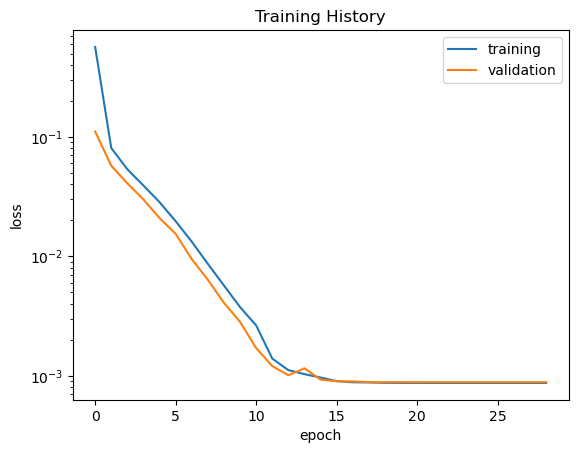

In [20]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [21]:
predict = model.predict(X_test)

63/63 [==============================] - 0s 325us/step


Text(0, 0.5, 'Prediction')

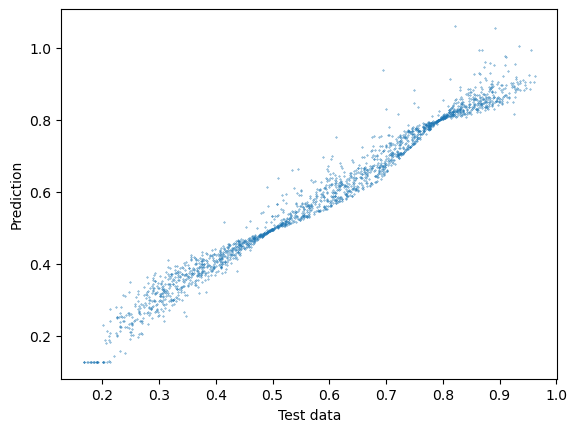

In [25]:
plt.scatter(y_test,predict.flatten(),s=0.1)
plt.xlabel('Test data')
plt.ylabel('Prediction')

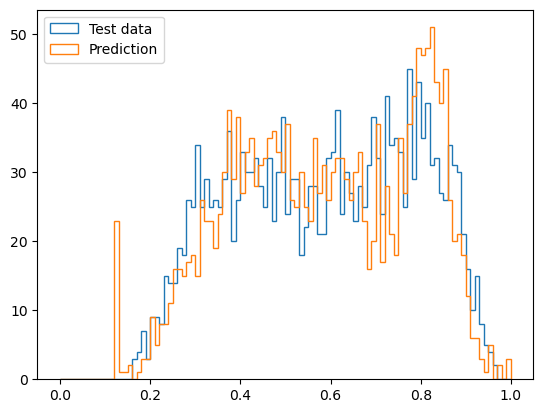

In [27]:
plt.hist(y_test,bins=100,range=(0,1),histtype='step',label='Test data')
plt.hist(predict.flatten(),bins=100,range=(0,1),histtype='step',label='Prediction')
plt.legend()

# Plot performce with 2D histograms

Text(0, 0.5, 'Prediction')

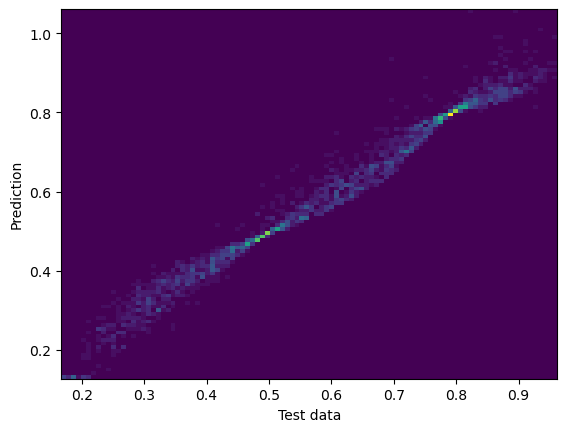

In [26]:
plt.hist2d(y_test, predict.flatten(), bins=(100,100))
plt.xlabel('Test data')
plt.ylabel('Prediction')

In [50]:
x1arr, x2arr = np.linspace(0,100,100), np.linspace(0,100,100)
x1mesh, x2mesh = np.meshgrid(x1arr, x2arr)
xplot = np.stack([x1mesh.reshape(10000,), x2mesh.reshape(10000,)], axis=-1)


In [57]:
yplot = model.predict(xplot)
yplot.shape

313/313 [==============================] - 0s 356us/step


(10000, 1)

Text(0.5, 1.0, '$\\tau_{32}$ trained model')

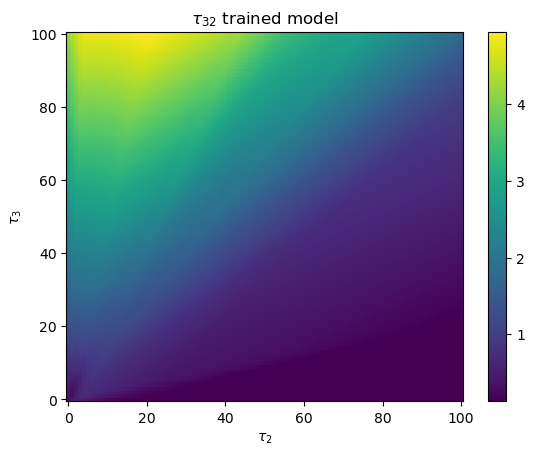

In [65]:
c = plt.pcolor(x1mesh,x2mesh, yplot.reshape(100,100))
plt.colorbar(c)
plt.xlabel(r'$\tau_2$')
plt.ylabel(r'$\tau_3$')
plt.title(r'$\tau_{32}$ trained model')